# Digital Manufacturing: Additive Scanning Subtractive 
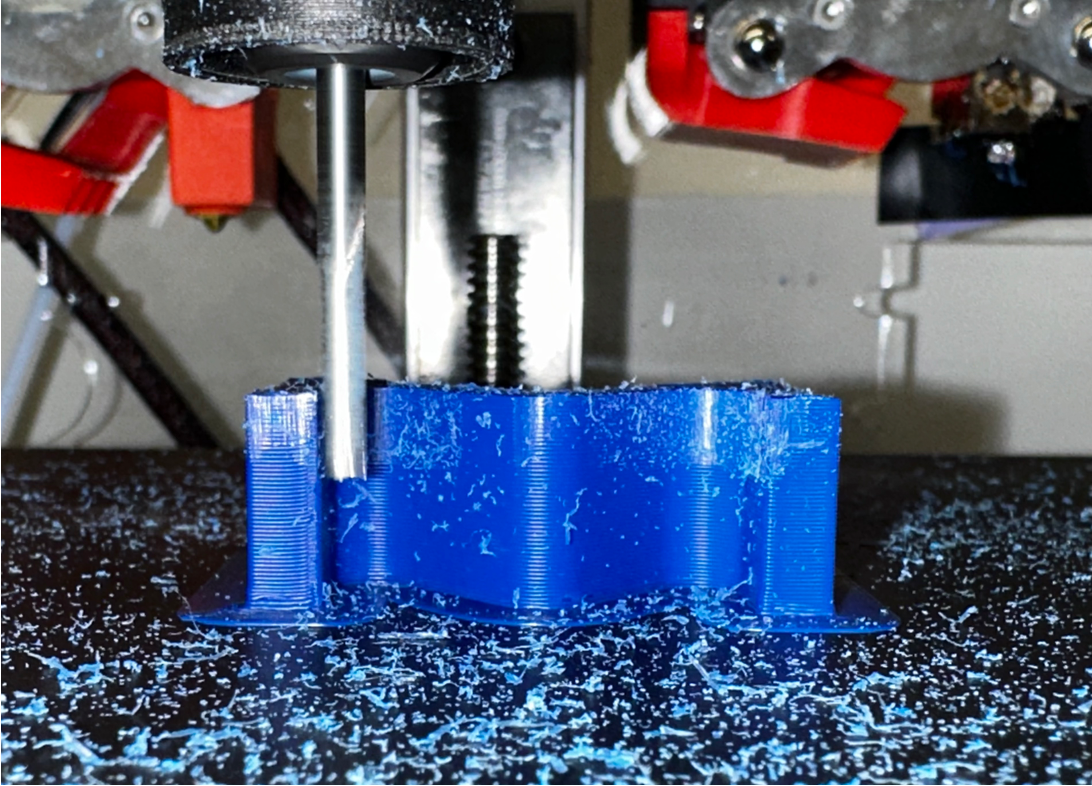

## Import Python libraries

In [1]:
import numpy as np
from typing import List, Tuple
import math
import pandas as pd
import csv

import trimesh
import trimesh.path

from shapely.geometry import Polygon, MultiPolygon, GeometryCollection, MultiLineString, Point, CAP_STYLE, JOIN_STYLE, LineString, LinearRing
from shapely.ops import linemerge, unary_union, transform
from shapely.affinity import rotate

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from scipy.ndimage import find_objects, binary_erosion, label, binary_dilation
from scipy.ndimage import binary_fill_holes

from skimage.measure import find_contours
from skimage import measure

from sympy import Point 

import requests
import logging
import subprocess
import os
import time

## Variables
* MaxCuttingDepth: The closest we allow the cutting tool to the printing bed in mm
* PassDepth: The depth of one cutting pass per revovlution in mm
* FeedRate: The traveling speed of the cutting tool in mm/min
* ToolThreeStartingLocation: The reference point of tool 3's starting location (X in mm, Y in mm)
* Scale_factor: The scaling factor in percentage of original stl file compared to printed part
* PixelsToFill: The amount of absent pixels to fill when processing scanner data
* scannerResolution: The dimensions of each individual pixel in the scanner data in mm
* ToolRadius: The radius of the cutting tool in mm
* ToolClearenceHeight: Distance to lower printing bed durring cutting tool entry and exit in mm
* ScanningClearence: The Z-axis offset from scanner to produce accurate scans in mm
* SearchRadius: The distance from currently selected reference point to search for new line segments to generate cutting path in mm

In [2]:
MaxCuttingDepth = 1 #The closest we allow the cutting tool to the printing bed in mm
PassDepth = 3 #The depth of one cutting pass per revovlution in mm 
FeedRate = 500 #The traveling speed of the cutting tool in mm/min
ToolThreeStartingLocation = (300, 200) #The reference point of tool 3's starting location (X in mm, Y in mm)
scale_factor = 1 #The scaling factor in percentage of original stl file compared to printed part
PixelsToFill = 20 #The amount of absent pixels to fill when processing scanner data
scannerResolution = 0.02 #The dimensions of each individual pixel in the scanner data in mm
ToolRadius = 1.5 #The radius of the cutting tool in mm
ToolClearenceHeight = 10 #Distance to lower printing bed durring cutting tool entry and exit in mm
ScanningClearence = 22 #The Z-axis offset from scanner to produce accurate scans in mm
SearchRadius = 2 #The distance from currently selected reference point to search for new line segments to generate cutting path in mm

## File Path's
* Location's for each file to download and upload data to the printer, scanner, and data processing functions.

In [3]:
stl_file_path = './Stl/40by25Mv4.stl'
g_code_file_path = './GCode/40by25Mv5.gcode'
scan_file_path = './DataProcessing/Scan/scannerOutput.csv'
OutputFileName = "test1"
base_url = "http://141.215.101.64"
scanner_ip_adress = '141.215.100.79'

## Functions
* Data processing 
* Exporting and receiving data from printer and scanner
* Cutting path generation logic
* G-code generation and export

In [4]:
# Functions for Processing Scanned CSV file
def change_to_one(x):
    if pd.notna(x) and isinstance(x, (int, float)):
        return 1
    return x

def fill_nans_between_ones_row(arr):
    for i in range(arr.shape[0]):
        row = arr[i]
        ones_indices = np.where(row == 1)[0]
        for j in range(len(ones_indices) - 1):
            start, end = ones_indices[j], ones_indices[j + 1]
            if np.isnan(row[start:end]).sum() <= PixelsToFill:
                row[start:end] = np.nan_to_num(row[start:end], nan=1)
        arr[i] = row
    return arr

def fill_nans_between_ones_col(arr):
    for i in range(arr.shape[1]):
        col = arr[:, i]
        ones_indices = np.where(col == 1)[0]
        for j in range(len(ones_indices) - 1):
            start, end = ones_indices[j], ones_indices[j + 1]
            if np.isnan(col[start:end]).sum() <= PixelsToFill:
                col[start:end] = np.nan_to_num(col[start:end], nan=1)
        arr[:, i] = col
    return arr

def keep_largest_body(arr):
    structure = np.ones((3, 3))  
    labeled_array, num_features = label(arr == 1, structure=structure)
    sizes = np.bincount(labeled_array.ravel())
    sizes[0] = 0  
    largest_body_label = sizes.argmax()
    largest_body_mask = labeled_array == largest_body_label
    arr[~largest_body_mask & (arr == 1)] = np.nan
    return arr


#functions for communicating with printer/scanner 

# Function to connect with password
def connect_with_password(password):
    rr_connect_url = f"{base_url}/rr_connect?password={password}"
    connect_response = requests.get(rr_connect_url)
    
    if connect_response.status_code == 200:
        print("Connected successfully")
    else:
        print(f"Failed to connect: {connect_response.status_code}")
        print(connect_response.text)
    return connect_response.status_code == 200

# Function to insert additional line after the last G command that doesn't have a ';' before it
def insert_line_after_last_g_command(file_path, additional_line):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Find the last G command that doesn't have a ';' before it
    last_g_command_index = -1
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith('G') and not line.startswith(';'):
            last_g_command_index = i
    
    # Insert the additional line after the found G command
    if last_g_command_index != -1:
        lines.insert(last_g_command_index + 1, additional_line + '\n')
    
    with open(file_path, 'w') as file:
        file.writelines(lines)

# Function to send the modified G-code file
def send_gcode_file(file_path):
    filename = file_path.split('/')[-1]  # Extract filename from path
    upload_url = f"{base_url}/rr_upload?name=/gcodes/{filename}"
    
    with open(file_path, 'rb') as file:
        response = requests.post(upload_url, data=file)
    
    if response.status_code == 200:
        print("G-code file sent successfully")
        return filename
    else:
        print(f"Failed to send G-code file: {response.status_code}")
        print(response.text)
        return None

# Function to send a G-code command
def send_gcode_command(command):
    rr_gcode_url = f"{base_url}/rr_gcode?gcode={command}"
    response = requests.get(rr_gcode_url)
    
    if response.status_code == 200:
        print(f"G-code command '{command}' sent successfully")
    else:
        print(f"Failed to send G-code command '{command}': {response.status_code}")
        print(response.text)

# Function to wait for the "heater" status to be 0 in the bed temperature
def wait_for_heater_off(base_url, interval=1):
    rr_status_url = f"{base_url}/rr_status?type=1"
    print(f"Constructed status URL: {rr_status_url}")  
    
    # Wait for 120 seconds before starting the check
    print("Waiting for 120 seconds before starting the check...")
    time.sleep(120)
    
    while True:
        try:
            response = requests.get(rr_status_url)
            if response.status_code == 200:
                status_data = response.json()
                #print(f"Status data received: {status_data}")
                if 'temps' in status_data and 'bed' in status_data['temps'] and status_data['temps']['bed']['state'] == 0:
                    print("Heater state is 0, stopping.")
                    break
            else:
                print(f"Failed to get status: {response.status_code}")
                print(response.text)
        except requests.ConnectionError as e:
            print(f"Connection error: {e}")
        
        time.sleep(interval)

        
# functions for generating cutting path
# Function to find the closest point
def find_closest_point(point, segments):
    min_dist = float('inf')
    closest_segment = None
    closest_point = None
    for segment in segments:
        for pt in segment:
            dist = point.distance(Point(pt))
            if dist < min_dist:
                min_dist = dist
                closest_segment = segment
                closest_point = pt
    return closest_segment, closest_point

# Convert the resulting lines to coordinate arrays without merging them
def lines_to_coords(geom):
    if isinstance(geom, LineString):
        return [np.array(geom.coords)]
    elif isinstance(geom, MultiLineString):
        return [np.array(line.coords) for line in geom.geoms]
    elif hasattr(geom, 'geoms'):  # Handle other collections of geometries
        coords = []
        for line in geom.geoms:
            coords.append(np.array(line.coords))
        return coords
    else:
        return []
    
def offset_lines(segments, offset_distance):
    offset_segments = []
    for segment in segments:
        line = LineString(segment)
        offset_line = line.parallel_offset(offset_distance, 'left')
        if isinstance(offset_line, MultiLineString):
            for offset_part in offset_line:
                offset_segments.append(np.array(offset_part.coords))
        else:
            offset_segments.append(np.array(offset_line.coords))
    return offset_segments

# Function to filter and adjust line segments
def filter_and_adjust_line_segments(polygon, segments):
    filtered_segments = []
    for segment in segments:
        # Convert numpy array to list of tuples
        line = LineString(segment.tolist())
        
        # Split the line by the polygon boundary
        difference = line.difference(polygon)
        
        # Handle different geometries that might result from the split
        if difference.geom_type == 'LineString':
            if not polygon.contains(difference):
                filtered_segments.append(np.array(difference.coords))
        elif difference.geom_type == 'MultiLineString':
            for part in difference.geoms:
                if not polygon.contains(part):
                    filtered_segments.append(np.array(part.coords))
        elif difference.geom_type == 'GeometryCollection':
            for part in difference:
                if part.geom_type == 'LineString' and not polygon.contains(part):
                    filtered_segments.append(np.array(part.coords))
    
    # Filter out any empty arrays
    filtered_segments = [seg for seg in filtered_segments if seg.size > 0]
    
    return filtered_segments

def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

def segment_length(segment):
    return distance(segment[0], segment[1])

def total_length(segments):
    return sum(segment_length(seg) for seg in segments)

def percent_difference(original_length, new_length):
    return abs(original_length - new_length) / original_length * 100

def closest_point(point, segments, used_segments):
    closest_p = None
    closest_seg = None
    min_dist = float('inf')
    for seg in segments:
        if tuple(map(tuple, seg)) in used_segments:
            continue
        for p in [seg[0], seg[1]]:
            dist = distance(point, p)
            if dist < min_dist:
                min_dist = dist
                closest_p = p
                closest_seg = seg
    return closest_p, closest_seg

def add_segment(new_list, segment, point, used_segments):
    if np.array_equal(point, segment[0]):
        new_list.append(segment)
    else:
        new_list.append(segment[::-1])
    used_segments.add(tuple(map(tuple, segment)))

def find_segments_with_starting_segment(start_segment, L1, L2):
    new_list = []
    used_segments = set()
    
    P1 = start_segment[1]  # Use the last point of the start segment as the starting point
    add_segment(new_list, start_segment, start_segment[0], used_segments)
    
    while len(used_segments) < len(L1) + len(L2) - 1:
        # Determine current and opposite lists based on the location of P1
        if any(np.array_equal(P1, seg[0]) or np.array_equal(P1, seg[1]) for seg in L1):
            current_list = L1
            opposite_list = L2
        else:
            current_list = L2
            opposite_list = L1
        
        # Find closest point and segment from the opposite list
        P2, S2 = closest_point(P1, opposite_list, used_segments)
        if S2 is None:
            break
        
        P4 = S2[1] if np.array_equal(P2, S2[0]) else S2[0]
        
        # Find closest point and segment from the current list
        P3, S3 = closest_point(P1, current_list, used_segments)
        if S3 is None:
            break
        
        P6 = S3[1] if np.array_equal(P3, S3[0]) else S3[0]
        
        # Check distances
        dist_P2 = distance(P1, P2)
        dist_P3 = distance(P1, P3)
        
        # If P2 is out of range (>3mm) and P3 is in range (<=3mm)
        if dist_P2 > SearchRadius and dist_P3 <= SearchRadius :
            add_segment(new_list, S3, P3, used_segments)
            P1 = P6
        # If P3 is out of range (>3mm) and P2 is in range (<=3mm)
        elif dist_P3 > SearchRadius and dist_P2 <= SearchRadius :
            add_segment(new_list, S2, P2, used_segments)
            P1 = P4
        # If both P2 and P3 are in range (<=3mm)
        else:
            P5, _ = closest_point(P4, current_list, used_segments)
            if np.array_equal(P3, P5):
                add_segment(new_list, S2, P2, used_segments)
                P1 = P4
            else:
                add_segment(new_list, S3, P3, used_segments)
                P1 = P6
    
    # Add the last remaining segment
    remaining_segments = [seg for seg in L1 + L2 if tuple(map(tuple, seg)) not in used_segments]
    if len(remaining_segments) == 1:
        last_segment = remaining_segments[0]
        last_point = P1
        add_segment(new_list, last_segment, last_point, used_segments)
    
    return new_list, used_segments

def find_best_starting_segment(L1, L2):
    original_total_length = total_length(L1) + total_length(L2)
    best_segments = []
    best_length_diff = float('inf')
    all_results = []
    
    for start_segment in L1 + L2:
        new_list, _ = find_segments_with_starting_segment(start_segment, L1, L2)
        new_list_length = total_length(new_list)
        pct_diff = percent_difference(original_total_length, new_list_length)
        
        all_results.append((pct_diff, new_list))
        
        #print(f"Starting segment: {start_segment}")
        #print(f"New list total length: {new_list_length:.2f}")
        #print(f"Percent difference: {pct_diff:.2f}%")
        
        if pct_diff < best_length_diff:
            best_segments = new_list
            best_length_diff = pct_diff
    
    # Find the list with the closest total length to the original total length
    all_results.sort(key=lambda x: x[0])
    
    print("\nPath Generated")
    #print(f"Percent difference: {all_results[0][0]:.2f}%")
    
    return all_results[0][1]

def extract_points_from_segments(merged_path):

    points = []
    
    
    for segment in merged_path:
        for point in segment:
            points.append(point)
    
    # Convert the list of points to a numpy array
    points_array = np.array(points)
    return points_array


# Functions for taking cutting path and converting it into coordinates

def convert_line_string_to_2d_array(line_string: LineString) -> np.ndarray:
    # Extract coordinates from the LineString object
    coords = list(line_string.coords)
    
    # Convert tuples to list of lists and then to a 2D NumPy array
    result = np.array([list(coord) for coord in coords])
    
    return result

def find_closest_coordinate(coordinates: np.ndarray, reference: Tuple[float, float]) -> Tuple[int, Tuple[float, float]]:
    # Debugging information
    print(f"Coordinates type: {type(coordinates)}")
    print(f"Coordinates shape: {coordinates.shape}")
    
    if not isinstance(coordinates, np.ndarray) or coordinates.ndim != 2 or coordinates.shape[1] != 2:
        raise ValueError("Coordinates must be a 2D NumPy array with shape (n, 2).")
    
    reference_array = np.array(reference)
    
    distances = np.sqrt(np.sum((coordinates - reference_array) ** 2, axis=1))
    min_index = np.argmin(distances)
    closest_coordinate = tuple(coordinates[min_index])
    
    return int(min_index), closest_coordinate

def find_closest_index(array, value):
    # Calculate the Euclidean distance between each row and the value
    distances = np.linalg.norm(array - value, axis=1)
    # Return the index of the minimum distance
    return np.argmin(distances)

def rearrange_2d_array(array, start_value):
    # Flatten the 2D array to 1D
    flat_array = array.reshape(-1, array.shape[-1])
    
    # Find the closest index of the start value
    start_index = find_closest_index(flat_array, start_value)
    
    # Rearrange the flat array to start from the start index
    rearranged_array = np.vstack((flat_array[start_index:], flat_array[:start_index]))
    
    # Reshape the 1D array back to 2D array with original shape
    reshaped_array = rearranged_array.reshape(array.shape)
    
    return reshaped_array


#Functions to convert coordinates into Gcode

# Function to print the specified pattern
def print_pattern(G, F, Z_start, Z_end, array):
    output = []
    Z = Z_start
    while Z >= Z_end:
        for pair in array:
            X, Y = pair
            output.append(f"G{G} X{round(X, 3)} Y{round(Y, 3)} Z{round(Z, 3)} F{F}")
        Z -= PassDepth
    return output
        

# Function to print the additional specified format
def print_start_format(ref_point, Z_var, array):
    outputStart = []
    ref_X, ref_Y = ref_point
    Z_value = round(Z_var + ToolClearenceHeight, 3)
    first_X, first_Y = array[0]
    
    outputStart.append("G1 U0 V-50 F1000 ; Move scanner back to starting location")
    outputStart.append("G21 ; set units to millimeters")
    outputStart.append("G90 ; use absolute coordinates")
    outputStart.append("T-1 ; Clear tool selection")
    outputStart.append("T3 ; Pick up subtractive tool")
    outputStart.append("M98 P/macros/InitializeServo1 ; Turn on subtractive tool")
    outputStart.append(f"G1 X{round(ref_X, 3)} Y{round(ref_Y, 3)} Z{Z_value} F{F}")
    outputStart.append(f"G1 X{round(first_X, 3)} Y{round(first_Y, 3)} Z{Z_value} F{F}")
    return outputStart

# Function to print the additional specified format
def print_end_format(ref_point, Z_var, array):
    outputEnd = []
    ref_X, ref_Y = ref_point
    Z_value = round(Z_var + 10, 3)
    first_X, first_Y = array[0]
    
    outputEnd.append(f"G1 X{round(first_X, 3)} Y{round(first_Y, 3)} Z{Z_value} F{F}")
    outputEnd.append(f"G1 X{round(ref_X, 3)} Y{round(ref_Y, 3)} Z{Z_value} F{F}")
    outputEnd.append("T-1 ; Turn off and put tool away")
    return outputEnd

#Functions for exporting compiled subtractive g code 


# Function to connect with password
def connect_with_password(password):
    try:
        rr_connect_url = f"{base_url}/rr_connect?password={password}"
        connect_response = requests.get(rr_connect_url)
        
        if connect_response.status_code == 200:
            logging.info("Connected successfully")
            return True
        else:
            logging.error(f"Failed to connect: {connect_response.status_code}")
            logging.error(connect_response.text)
            return False
    except Exception as e:
        logging.error(f"Exception occurred during connection: {e}")
        return False

# Function to save combined output to a G-code file
def save_combined_output_to_file(combined_output, file_path):
    try:
        # Join list elements into a single string
        combined_output_str = '\n'.join(combined_output)
        with open(file_path, 'w') as file:
            file.write(combined_output_str)
        logging.info(f"Combined output saved to {file_path}")
    except Exception as e:
        logging.error(f"Exception occurred while saving to file: {e}")

# Function to send the G-code file
def send_gcode_file(file_path):
    try:
        filename = os.path.basename(file_path)  # Extract filename from path
        upload_url = f"{base_url}/rr_upload?name=/gcodes/{filename}"
        
        with open(file_path, 'rb') as file:
            response = requests.post(upload_url, data=file)
        
        if response.status_code == 200:
            logging.info("G-code file sent successfully")
            return filename
        else:
            logging.error(f"Failed to send G-code file: {response.status_code}")
            logging.error(response.text)
            return None
    except Exception as e:
        logging.error(f"Exception occurred while sending G-code file: {e}")
        return None

# Function to send a G-code command
def send_gcode_command(command):
    try:
        rr_gcode_url = f"{base_url}/rr_gcode?gcode={command}"
        response = requests.get(rr_gcode_url)
        
        if response.status_code == 200:
            logging.info(f"G-code command '{command}' sent successfully")
        else:
            logging.error(f"Failed to send G-code command '{command}': {response.status_code}")
            logging.error(response.text)
    except Exception as e:
        logging.error(f"Exception occurred while sending G-code command: {e}")



## Importing STL file and creating 3D refrence model
* Taking a cross section to create a refrence plane
* From refrence plane create a boundary off of the exterior profile
* Compute the X, Y, and Z offset to find the parts location on printing bed and height of model 

In [ ]:
mesh = trimesh.load_mesh(stl_file_path)  
mesh.apply_scale(scale_factor)
xOffset = mesh.bounds[0,0]+ (0.5*(mesh.bounds[1,0]-mesh.bounds[0,0]))
yOffset = mesh.bounds[0,1]+ (0.5*(mesh.bounds[1,1]-mesh.bounds[0,1]))
PartHeight = mesh.bounds[1,2]
#print("Initial bounding box dimensions:", mesh.bounds)
#print("Scaled bounding box dimensions:", mesh.bounds)
print(f"X Offset = {xOffset}, Y Offset = {yOffset} Z Max = {PartHeight}")
Profile2d = trimesh.path.polygons.projected(mesh,[0,0,1],origin=None, ignore_sign=True, rpad=1e-05, apad=None, tol_dot=0.01,) # max_regions=200
#trimesh.path.polygons.plot(polygon=Profile2d, show=True, axes=None)
originalVertices = np.array(Profile2d.exterior.coords)
shape = trimesh.Scene(mesh,'world')
trimesh.Scene.show(shape)

## Exporting original Gcode
* Adds the commands to center scanner over printed part once printing is completed
* Sends updated G-code to printer to start additive process 

In [6]:
def main():
    password = "your_password"  
    gcode_file_path = g_code_file_path  # Path to the uploaded file

    # Calculate the Z height
    z_height = PartHeight + ScanningClearence

    # Additional line to add to the G-code file
    additional_line = f"G1 U152.5 V232 Z{z_height}"  # Use the calculated Z height

    # Connect with password
    if connect_with_password(password):
        # Insert the additional line after the last G command that doesn't have a ';' before it
        insert_line_after_last_g_command(gcode_file_path, additional_line)
        # Send the modified G-code file
        filename = send_gcode_file(gcode_file_path)
        if filename:
            # Send M23 command to select the file
            send_gcode_command(f"M23 {filename}")
            # Send M24 command to start the print
            send_gcode_command("M24")

if __name__ == "__main__":
    main()


## Automation process to delay scanner from operating till additive process has finished.

In [ ]:
if __name__ == "__main__":  
    wait_for_heater_off(base_url)

## Activating Gocator Scanner
* Triggers scanner and deposites buffer into holding file

In [ ]:
output_file = 'AdditiveScanningSubtractive/DataProcessing/Buffer/testoutputbuffer.gprec'

os.environ['WINEDEBUG'] = '-all'


command = [
    'wine', 
    './DataProcessing/RecordandDownload/ReplayData.exe',  
    output_file,
    scanner_ip_adress
]


result = subprocess.run(command, capture_output=True, text=True)

print("Output:", result.stdout)
print("Errors:", result.stderr)
print("Return code:", result.returncode)

if result.returncode == 0:
    print("Command executed successfully.")
else:
    print("Command execution failed.")

## Function to convert scanned file from .gprec to .csv for easier data processing 

In [ ]:

output_file = scan_file_path
input_file = './DataProcessing/Buffer/testoutputbuffer.gprec'
if not os.path.isfile(input_file):
    print(f"Error: Input file {input_file} does not exist.")
else:
    os.environ['WINEDEBUG'] = '-all'

    
    command = [
        'wine', 
        './DataProcessing/ReplayConverter/ReplayConverter.exe', 
        '-i', input_file, 
        '-f', '0', 
        '-o', output_file
    ]

    # Run the command
    result = subprocess.run(command, capture_output=True, text=True)

    # Output the result
    print("Output:", result.stdout)
    print("Errors:", result.stderr)
    print("Return code:", result.returncode)

    # Check if the command ran successfully
    if result.returncode == 0:
        print("Command executed successfully.")
    else:
        print("Command execution failed.")


## Processing scanner data
* Loading in scanned data as plain text then cleaning up data so that we are left with only the X,Y, and heightmap
* Dropping all of the rows and columns that are left blank to reduce file size
* Taking the height map and replacing any real values with 1's so that we are left with "NaN's" and "1's" to ease data processing
* Sorting through the clusters of 1's and finding the largest independent island and removing all other clusters to isolate the part.
* Filling in the empty NaN spaces that fall between two 1's befor: [ 1 NaN NaN NaN NaN 1 ], after: [ 1 1 1 1 1 1 ]
* Repeating this process through all of the rows and then columns
* Output the heightmap with only the isolated part data that has been cleaned

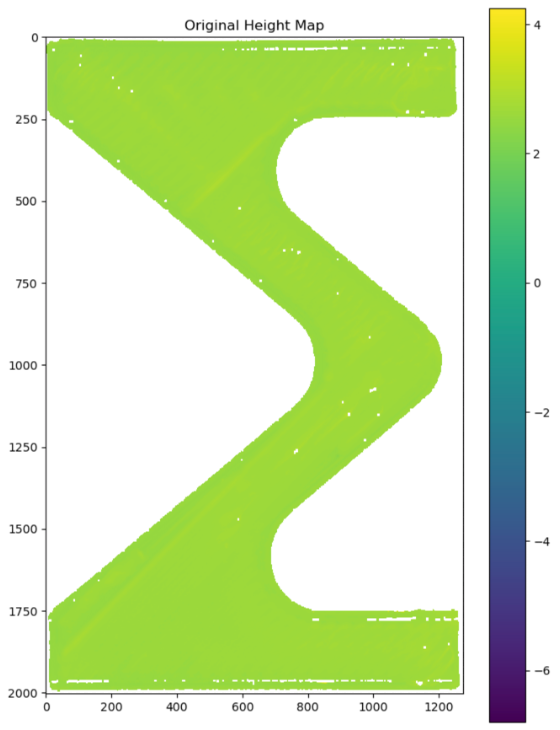
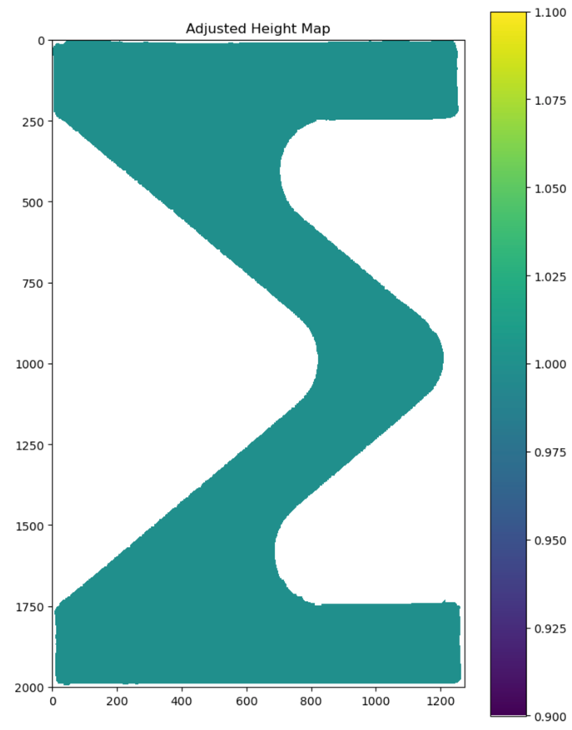

In [15]:
with open(scan_file_path, 'r') as file:
    lines = file.readlines()

scanned_data = [line.strip().split(',') for line in lines]


scanned = pd.DataFrame(scanned_data)
                          
#Clean dataframe
scanned = scanned.iloc[27:]
scanned = scanned.apply(pd.to_numeric, errors='ignore') 
cols_to_drop = scanned.columns[scanned.notna().sum() < 3]
rows_to_drop = scanned.notna().sum(axis=1) < 3
scanned = scanned.drop(columns=cols_to_drop)
scanned = scanned[~rows_to_drop]
scanned.columns = range(len(scanned.columns))
scanned.reset_index(drop=True, inplace=True)
#scanned

#isolate Height Map
xAxisArray = scanned.iloc[1,1:].to_numpy()
yAxisArray = scanned.iloc[1:,0].to_numpy()
heightMap = scanned.iloc[1:,1:].to_numpy()

#Process Height Map 
scanned.iloc[1:, 1:] = scanned.iloc[1:, 1:].map(change_to_one)
heightMapOne = scanned.iloc[1:,1:].to_numpy()
heightMapSingle = keep_largest_body(heightMapOne)
heightMapRow = fill_nans_between_ones_row(heightMapSingle)
heightMapTotall = fill_nans_between_ones_col(heightMapRow)
heightMapSingle = keep_largest_body(heightMapTotall)



/tmp/ipykernel_34319/677027629.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  scanned = scanned.apply(pd.to_numeric, errors='ignore')


## Visualizing scanned file pre and post data processing

In [ ]:
plt.figure(figsize=(8, 11))
plt.title('Original Height Map')
plt.imshow(heightMap.astype(float), cmap='viridis')  # 'viridis' is just an example colormap, you can choose others
plt.colorbar()  # Add a color bar for reference
plt.show()

plt.figure(figsize=(8, 11))
plt.title('Adjusted Height Map')
plt.imshow(heightMapTotall, cmap='viridis')  # 'viridis' is just an example colormap, you can choose others
plt.colorbar()  # Add a color bar for reference
plt.show()

threshold = 0.5
heightMapSingle = np.where(heightMapSingle == None, np.nan, heightMapSingle).astype(float)
binary_mask = heightMapRow > threshold

plt.figure(figsize=(8, 11))
plt.imshow(binary_mask, cmap='gray', interpolation='nearest')
plt.show()
contours = find_contours(binary_mask,0.5)
boundary_points = np.concatenate(contours,)
boundary_points = [(point[0], point[1]) for point in boundary_points]
scannedShape = Polygon(boundary_points)


## Creating a boundary based off of the scanner data and overlaying it with the boundary based off of the original part file. 
* Creating a boundary from the exterior shape of the scanned data
* Overlay the scanned boundary with the original stl boundary created previously
* Color code overlaping sections to identify defective sections
  
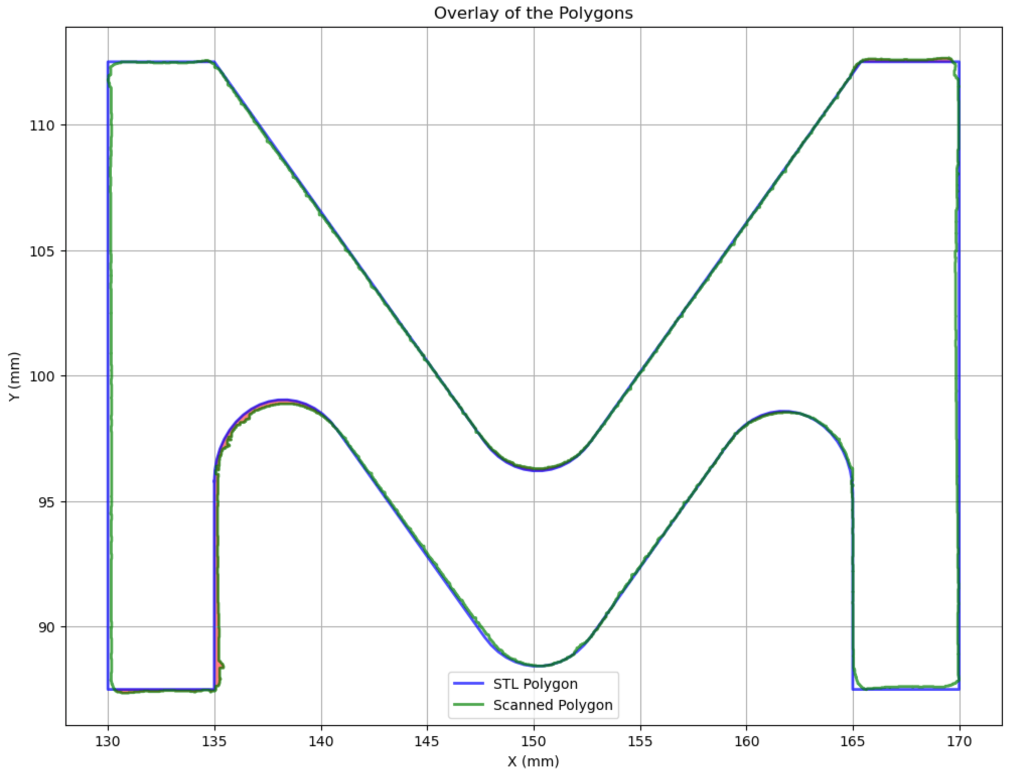
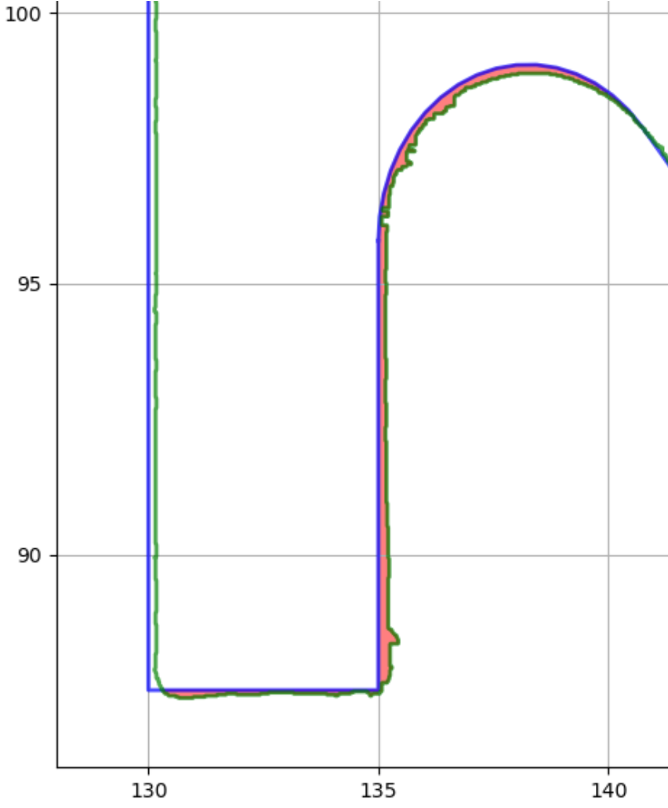

In [ ]:
#Rotating scanned shape
scannedShape = rotate(scannedShape, 179.75, origin='center')
#Scale the size of the scan by the scanner resolution:
scannedShape = Polygon([(x * scannerResolution, y * scannerResolution) for x, y in scannedShape.exterior.coords])

#Finds bounds of the scanned
scannedShapeBounds = scannedShape.bounds
xBound = scannedShapeBounds[0]+ (0.5*(scannedShapeBounds[2]-scannedShapeBounds[0]))
yBound = scannedShapeBounds[1]+ (0.5*(scannedShapeBounds[3]-scannedShapeBounds[1]))
# Move the polygon by applying the translation offsets so it lines up with the position of the part:
scannedShape = Polygon([(x + xOffset-xBound, y + yOffset-yBound) for x, 
                        y in scannedShape.exterior.coords])

x_coords, y_coords = scannedShape.exterior.xy
# Plot the polygon
plt.figure(figsize=(12, 9))
plt.plot(x_coords, y_coords, color='blue', alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2)
plt.fill(x_coords, y_coords, color='lightblue', alpha=0.5, zorder=1)
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Scanned Polygon Boundary')
plt.grid(True)
plt.show()

# Overlay the polygons
overlay_polygon = scannedShape.difference(Profile2d)
#overlay_polygon = Profile2d.difference(scannedShape)
# Plot the polygons and overlay
fig, ax = plt.subplots(figsize=(24, 18))

# Plot polygon 1
x1, y1 = Profile2d.exterior.xy
ax.plot(x1, y1, color='blue', alpha=0.7, linewidth=2, label='STL Polygon')

# Plot polygon 2
x2, y2 = scannedShape.exterior.xy
ax.plot(x2, y2, color='green', alpha=0.7, linewidth=2, label='Scanned Polygon')

# Plot overlay polygon
if isinstance(overlay_polygon, Polygon):
    x_overlay, y_overlay = overlay_polygon.exterior.xy
    ax.fill(x_overlay, y_overlay, color='red', alpha=0.5, label='Overlay')
elif isinstance(overlay_polygon, MultiPolygon) or isinstance(overlay_polygon, GeometryCollection):
    for geom in overlay_polygon.geoms:
        if isinstance(geom, Polygon):
            x_overlay, y_overlay = geom.exterior.xy
            ax.fill(x_overlay, y_overlay, color='red', alpha=0.5)

# Set plot attributes
ax.set_title('Overlay of the Polygons')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.legend()
ax.grid(True)

plt.show()

## Generating cutting path based off of identified defected sections of printed part
* Take the identified defective sections of the original boundary and offset them by the cutting tools radius creating a cutting segment
* Take the non-defective sections of the original boundary and offset them by the cutting tools diameter creating a clearence segment
* Store these in two seperate arrays for cutting path generation.
* Take the two arrays and process them segment by segment using the cutting path logic defined
* This logic orders the segments by finding the closest segments within a specified distance
* Then determing which of these segments will lead to having all of the segments used from each array
* The goal of this to create a singular path that uses all of the stored cutting segments and clearence segments withought crossing the original parts boundary.

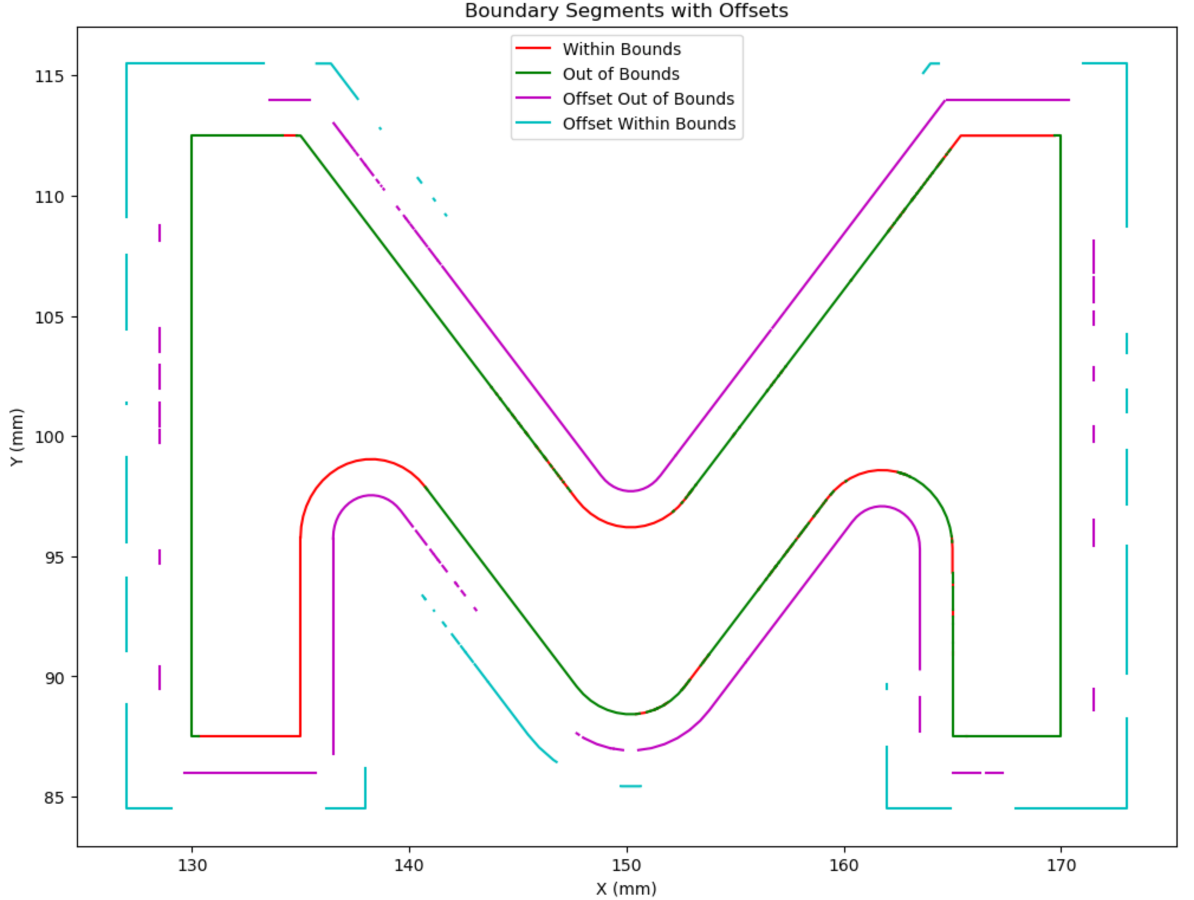
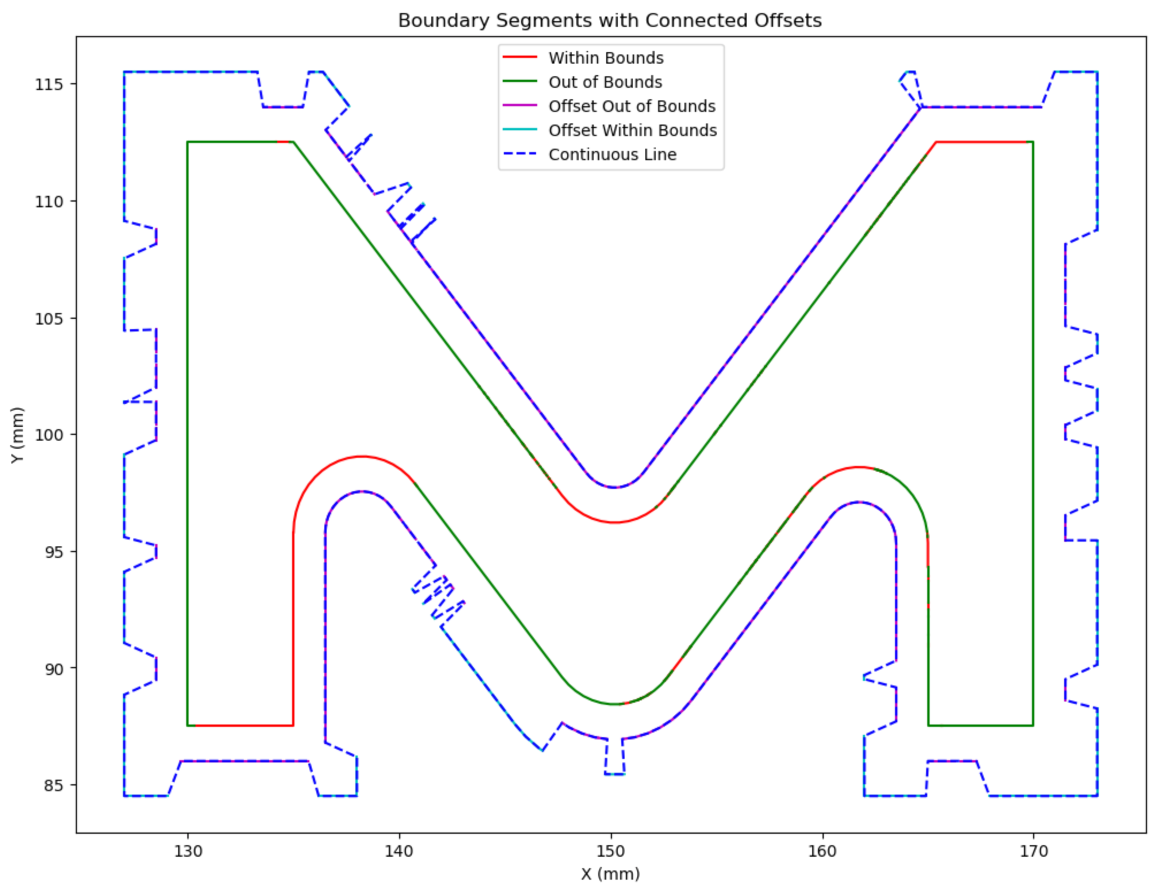

In [19]:
# Original shapes
original_shape = Profile2d
scanned_shape = scannedShape
original_boundary = LineString(original_shape.exterior.coords)
boundary_polygon = Polygon(original_boundary)
# offsets
original_shape_r = Profile2d.buffer(ToolRadius, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)
scanned_shape_r = scannedShape.buffer(ToolRadius, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)
original_shape_two_r = Profile2d.buffer(ToolRadius*2, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)
scanned_shape_two_r = scannedShape.buffer(ToolRadius*2, cap_style=CAP_STYLE.flat, join_style=JOIN_STYLE.mitre)

original_boundary = LineString(original_shape.exterior.coords)
intersection_lines = original_boundary.intersection(scanned_shape)
within_bounds = original_boundary.intersection(scanned_shape)
out_of_bounds = original_boundary.difference(within_bounds)

original_boundary_r = LineString(original_shape_r.exterior.coords)
intersection_lines_r = original_boundary_r.intersection(scanned_shape_r)
within_bounds_r = original_boundary_r.intersection(scanned_shape_r)
out_of_bounds_r = original_boundary_r.difference(within_bounds_r)

original_boundary_two_r = LineString(original_shape_two_r.exterior.coords)
intersection_lines_two_r = original_boundary_two_r.intersection(scanned_shape_two_r)
within_bounds_two_r = original_boundary_two_r.intersection(scanned_shape_two_r)
out_of_bounds_two_r = original_boundary_two_r.difference(within_bounds_two_r)

boundary_within_bounds = lines_to_coords(within_bounds)
boundary_out_of_bounds = lines_to_coords(out_of_bounds)

boundary_within_bounds_r = lines_to_coords(within_bounds_r)
boundary_out_of_bounds_r = lines_to_coords(out_of_bounds_r)

boundary_within_bounds_two_r = lines_to_coords(within_bounds_two_r)
boundary_out_of_bounds_two_r = lines_to_coords(out_of_bounds_two_r)

offsetPolygon = Profile2d.buffer(2*ToolRadius*0.99)
#print(boundary_out_of_bounds_two_r)
#print(boundary_within_bounds_r)

# Filter and adjust the line segments
filtered_segments = filter_and_adjust_line_segments(offsetPolygon, boundary_out_of_bounds_two_r)

# Print the results
#print("Filtered and Adjusted Line Segments (On the border or outside):")
#for segment in filtered_segments:
#    print(segment)

result = find_best_starting_segment(filtered_segments, boundary_within_bounds_r)
#print("Result segments:")
#for seg in result:
#    print(seg)

points_array = extract_points_from_segments(result)    


Path Generated


 ## visualizations of cutting path generation

In [ ]:
def plot_segments(segments, color, label):
    for segment in segments:
        plt.plot(segment[:, 0], segment[:, 1], color=color, label=label)
        label = "_nolegend_"  # Prevents duplicate labels in legend
fig, ax = plt.subplots(figsize=(12, 9))
# Plot the original boundary
original_coords = np.array(original_boundary.coords)

# Plot the within bounds segments
plot_segments(boundary_within_bounds, 'r', 'Within Bounds')

# Plot the out of bounds segments
plot_segments(boundary_out_of_bounds, 'g', 'Out of Bounds')

# Plot the offset out of bounds segments
plot_segments(boundary_within_bounds_r, 'm', 'Offset Out of Bounds')

# Plot the offset within bounds segments
plot_segments(boundary_out_of_bounds_two_r, 'c', 'Offset Within Bounds')

original_coordss = np.array(offsetPolygon.exterior.coords)

# Display settings
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Boundary Segments with Offsets')
plt.legend()
plt.show()

def plot_segments(segments, color, label):
    for segment in segments:
        plt.plot(segment[:, 0], segment[:, 1], color=color, label=label)
        label = "_nolegend_"  
fig, ax = plt.subplots(figsize=(12, 9))
# Plot the original boundary
original_coords = np.array(original_boundary.coords)

# Plot the within bounds segments
plot_segments(boundary_within_bounds, 'r', 'Within Bounds')

# Plot the out of bounds segments
plot_segments(boundary_out_of_bounds, 'g', 'Out of Bounds')

# Plot the offset out of bounds segments
plot_segments(boundary_within_bounds_r, 'm', 'Offset Out of Bounds')

# Plot the offset within bounds segments
plot_segments(boundary_out_of_bounds_two_r, 'c', 'Offset Within Bounds')

continuous_line_coords = np.array(points_array)
plt.plot(continuous_line_coords[:, 0], continuous_line_coords[:, 1], 'b--', label='Continuous Line')


plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Boundary Segments with Connected Offsets')
plt.legend()
plt.show()


## Reordering cutting path based on milling tool location and converting the path from an ordered list of line segments and converting them into cartesian coordinates.
* The outputted list of line segments need to be converted into a list coordinates to do this we break down each line segment into the points that they are comprised of
* Then we take this new list of points and reorder them so that it starts at the point closest to the cutting tools location

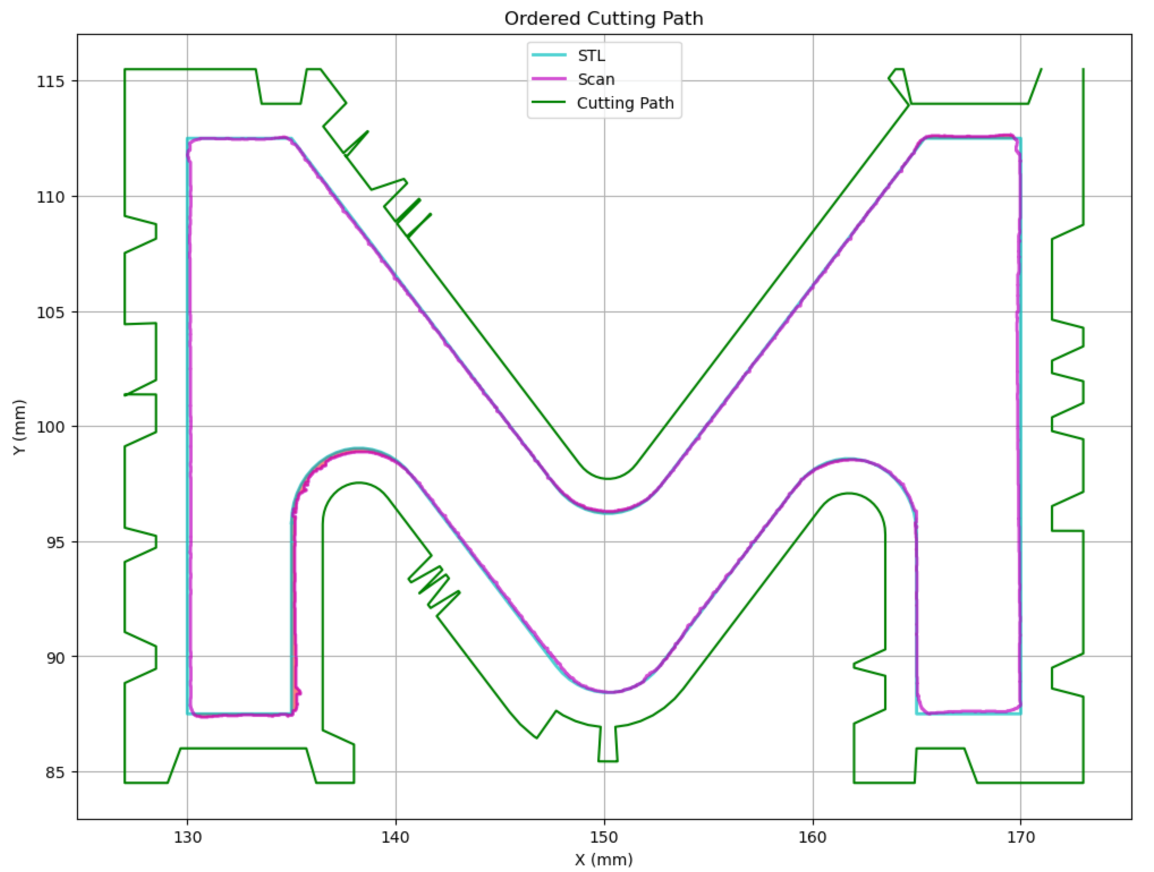

Coordinates type: <class 'numpy.ndarray'>
Coordinates shape: (393, 2)


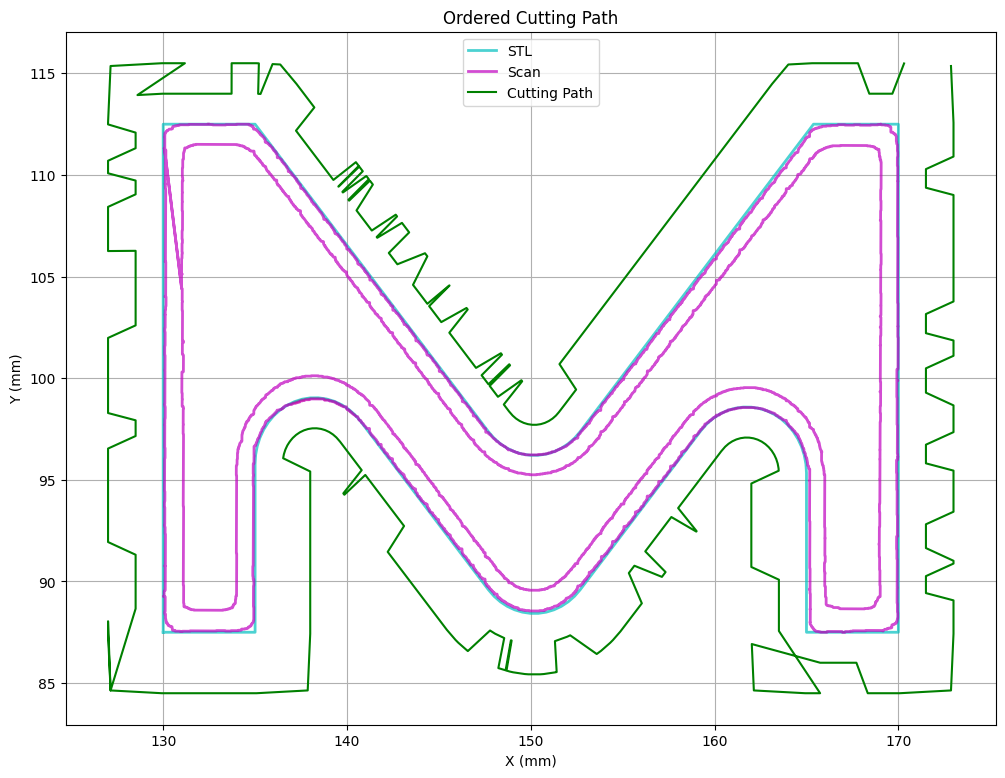

In [22]:
reference = ToolThreeStartingLocation  # Reference point
reference_polygon = Profile2d
closest_index, closest = find_closest_coordinate(points_array, reference)
# Call the function
original_array = points_array
start_value = closest
rearranged_array = rearrange_2d_array(original_array, start_value)
#print(rearranged_array)


overlay_polygon = scannedShape.difference(Profile2d)

# Plot the polygons and overlay
fig, ax = plt.subplots(figsize=(12, 9))

# Plot polygon 1
x1, y1 = Profile2d.exterior.xy
ax.plot(x1, y1, color='c', alpha=0.7, linewidth=2, label='STL')

# Plot polygon 2
x2, y2 = scannedShape.exterior.xy
ax.plot(x2, y2, color='m', alpha=0.7, linewidth=2, label='Scan')

# Plot overlay polygon
if isinstance(overlay_polygon, Polygon):
    x_overlay, y_overlay = overlay_polygon.exterior.xy
    ax.fill(x_overlay, y_overlay, color='red', alpha=0.5, label='Overlay')
elif isinstance(overlay_polygon, MultiPolygon) or isinstance(overlay_polygon, GeometryCollection):
    for geom in overlay_polygon.geoms:
        if isinstance(geom, Polygon):
            x_overlay, y_overlay = geom.exterior.xy
            ax.fill(x_overlay, y_overlay, color='red', alpha=0.5)
continuous_line_coords = rearranged_array
#plt.plot(continuous_line_coords[:, 0], continuous_line_coords[:, 1], 'b-', label='Continuous Line')
plt.plot(rearranged_array[:, 0], rearranged_array[:, 1], 'g', label='Cutting Path')

# Set plot attributes
ax.set_title('Ordered Cutting Path')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.legend()
ax.grid(True)

plt.show()

## Constructing G-Code
* Take the new list of points and convert them into a string of G-code commands
* Refrencing the parts original height we use this as a starting height for the cutting path
* Then we itterate the cutting path at decreasing heights determined by the path depth untill a minimum height is reached

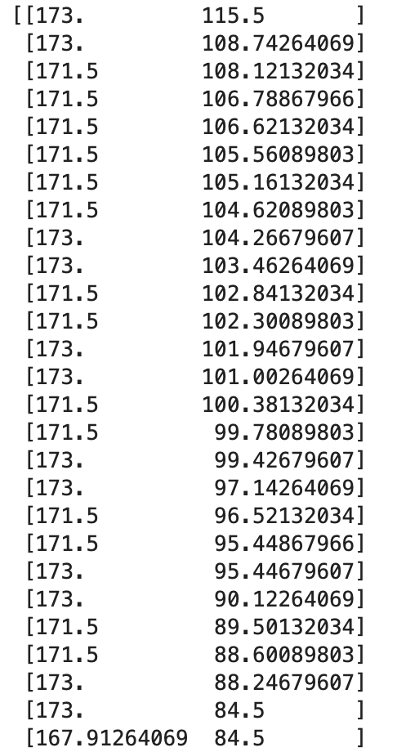
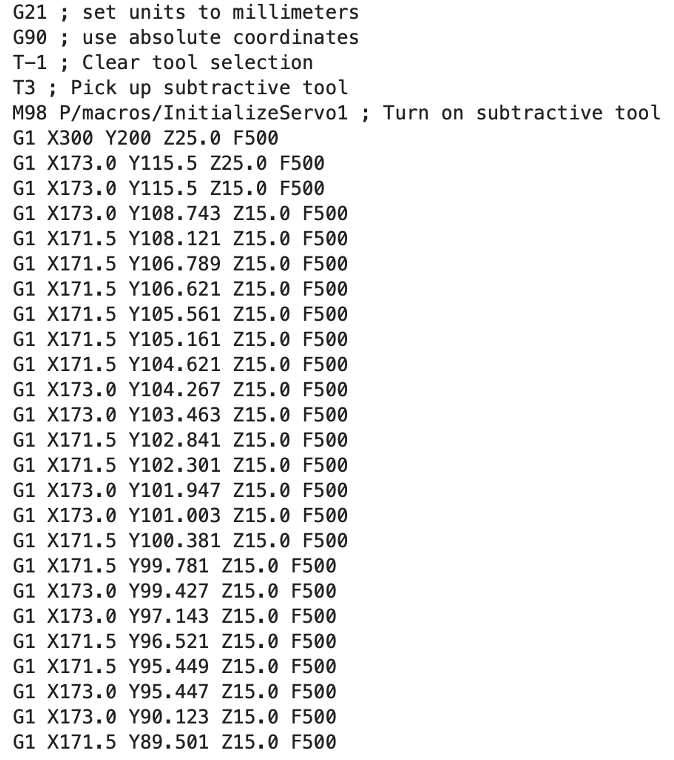

In [23]:
# Constants
G = 1  # Replace with the actual G value
F = FeedRate  # Replace with the actual F value
StartingHeight = PartHeight
Z_start = StartingHeight # Replace with the actual start value for Z
Z_end = MaxCuttingDepth    # Replace with the actual end value for Z

# Reference point for X and Y
ref_point = ToolThreeStartingLocation  # Replace with the actual reference X and Y values
Z_var = StartingHeight  # Replace with the actual Z variable value

# 2D array of X and Y values
array = rearranged_array
    
# Print the start format
#print(print_start_format(ref_point, Z_var, array))   
# Print the main pattern
#print(print_pattern(G, F, Z_start, Z_end, array))
# Print the end format
#print(print_end_format(ref_point, Z_var, array))

# Collect all outputs
combined_output = []
combined_output.extend(print_start_format(ref_point, Z_var, array))
combined_output.extend(print_pattern(G, F, Z_start, Z_end, array))
combined_output.extend(print_end_format(ref_point, Z_var, array))
# Print the combined output
#for line in combined_output:
   # print(line)
print('G-code Generated')

G-code Generated


## Exporting Gcode to toolChanger

In [24]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
base_url = "http://141.215.101.64"
def main():
    PASSWORD = "your_password"
    subtractive_gcode_file_path = f"{OutputFileName}subtractive.gcode"  # Define the output file name
    
    # Connect with password
    if connect_with_password(PASSWORD):
        # Save combined output to a G-code file
        save_combined_output_to_file(combined_output, subtractive_gcode_file_path)
        # Send the G-code file
        filename = send_gcode_file(subtractive_gcode_file_path)
        if filename:
            # Send M23 command to select the file
            send_gcode_command(f"M23 {filename}")
            # Send M24 command to start the print
            send_gcode_command("M24")

if __name__ == "__main__":
    main()